In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
# import scipy
import numpy as np

In [10]:
solution = 0.1 # g/l
solution_ug = solution * 10**6 # ug/l
solution_ug_ml = solution_ug / 10**3 # ug/ml
solution_ug_ml

100.0

In [11]:
files = glob.glob("*.tab")

In [12]:
files

['12.5.tab',
 '12.6.tab',
 '14.5.second.tab',
 'log14.5.tab',
 'log14.6.second.tab',
 'log14.6.tab',
 'log3.5.second.tab',
 'log3.5.tab',
 'log3.5.third.tab',
 'log3.6.second.tab',
 'log3.6.tab',
 'log3.6.third.tab',
 'log4.5.tab',
 'log4.6.tab']

In [16]:
    
def _basic_simpson(y, start, stop, x, dx, axis):
    nd = len(y.shape)
    if start is None:
        start = 0
    step = 2
    slice_all = (slice(None),)*nd
    slice0 = tupleset(slice_all, axis, slice(start, stop, step))
    slice1 = tupleset(slice_all, axis, slice(start+1, stop+1, step))
    slice2 = tupleset(slice_all, axis, slice(start+2, stop+2, step))

    if x is None:  # Even-spaced Simpson's rule.
        result = np.sum(y[slice0] + 4.0*y[slice1] + y[slice2], axis=axis)
        result *= dx / 3.0
    else:
        # Account for possibly different spacings.
        #    Simpson's rule changes a bit.
        h = np.diff(x, axis=axis)
        sl0 = tupleset(slice_all, axis, slice(start, stop, step))
        sl1 = tupleset(slice_all, axis, slice(start+1, stop+1, step))
        h0 = np.float64(h[sl0])
        h1 = np.float64(h[sl1])
        hsum = h0 + h1
        hprod = h0 * h1
        h0divh1 = np.true_divide(h0, h1, out=np.zeros_like(h0), where=h1 != 0)
        tmp = hsum/6.0 * (y[slice0] *
                          (2.0 - np.true_divide(1.0, h0divh1,
                                                out=np.zeros_like(h0divh1),
                                                where=h0divh1 != 0)) +
                          y[slice1] * (hsum *
                                       np.true_divide(hsum, hprod,
                                                      out=np.zeros_like(hsum),
                                                      where=hprod != 0)) +
                          y[slice2] * (2.0 - h0divh1))
        result = np.sum(tmp, axis=axis)
    return result


def simpson(y, x=None, dx=1.0, axis=-1, even='avg'):
    y = np.asarray(y)
    nd = len(y.shape)
    N = y.shape[axis]
    last_dx = dx
    first_dx = dx
    returnshape = 0
    if x is not None:
        x = np.asarray(x)
        if len(x.shape) == 1:
            shapex = [1] * nd
            shapex[axis] = x.shape[0]
            saveshape = x.shape
            returnshape = 1
            x = x.reshape(tuple(shapex))
        elif len(x.shape) != len(y.shape):
            raise ValueError("If given, shape of x must be 1-D or the "
                             "same as y.")
        if x.shape[axis] != N:
            raise ValueError("If given, length of x along axis must be the "
                             "same as y.")
    if N % 2 == 0:
        val = 0.0
        result = 0.0
        slice1 = (slice(None),)*nd
        slice2 = (slice(None),)*nd
        if even not in ['avg', 'last', 'first']:
            raise ValueError("Parameter 'even' must be "
                             "'avg', 'last', or 'first'.")
        # Compute using Simpson's rule on first intervals
        if even in ['avg', 'first']:
            slice1 = tupleset(slice1, axis, -1)
            slice2 = tupleset(slice2, axis, -2)
            if x is not None:
                last_dx = x[slice1] - x[slice2]
            val += 0.5*last_dx*(y[slice1]+y[slice2])
            result = _basic_simpson(y, 0, N-3, x, dx, axis)
        # Compute using Simpson's rule on last set of intervals
        if even in ['avg', 'last']:
            slice1 = tupleset(slice1, axis, 0)
            slice2 = tupleset(slice2, axis, 1)
            if x is not None:
                first_dx = x[tuple(slice2)] - x[tuple(slice1)]
            val += 0.5*first_dx*(y[slice2]+y[slice1])
            result += _basic_simpson(y, 1, N-2, x, dx, axis)
        if even == 'avg':
            val /= 2.0
            result /= 2.0
        result = result + val
    else:
        result = _basic_simpson(y, 0, N-2, x, dx, axis)
    if returnshape:
        x = x.reshape(saveshape)
    return result  


def tupleset(t, i, value):
    l = list(t)
    l[i] = value
    return tuple(l)

In [17]:
def plot(index):
    df = pd.read_csv(files[index],delimiter="\t",skiprows=1,index_col=0, parse_dates=True)
    fig, ax = plt.subplots(1,2, figsize=(12,5))
    zero = df['Rhodamine (ug/L)'].iloc[:20].mean()
    df['Rhodamine (ug/L)']  = df['Rhodamine (ug/L)'] - zero
    df[['Rhodamine (ug/L)']].plot(ax=ax[0])
    df[['Temp (C)']].plot(ax=ax[1])

    title = files[index][:files[index].find(".tab")]
    
    ax[0].set_ylabel('Rhodamine (ug/L)')
    
    ax[1].set_ylabel('Temp (C)')
    
    area = simpson(df['Rhodamine (ug/L)'].to_numpy(),dx=2)
    
    try:
        with open(files[index]) as fin:
            for i, row in enumerate(fin):
                if i == 0:
                    val = row[row.find("-")+2:].strip()[:-2]
                    ml_added = int(val)
    except Exception as e:
        ml_added = int(input("What was the input ml (int)"))
    
    ug_added = solution_ug_ml * ml_added 
    discharge = ug_added/area 
    
    ax[0].set_title(title + f' - Q:{discharge:.2f} l/s with {ml_added}ml')
    return df, fig, val

In [18]:
df4, fig4, val4 = plot(4)

In [70]:
df2, fig2, val2 = plot(0)

What was the input ml (int) 108


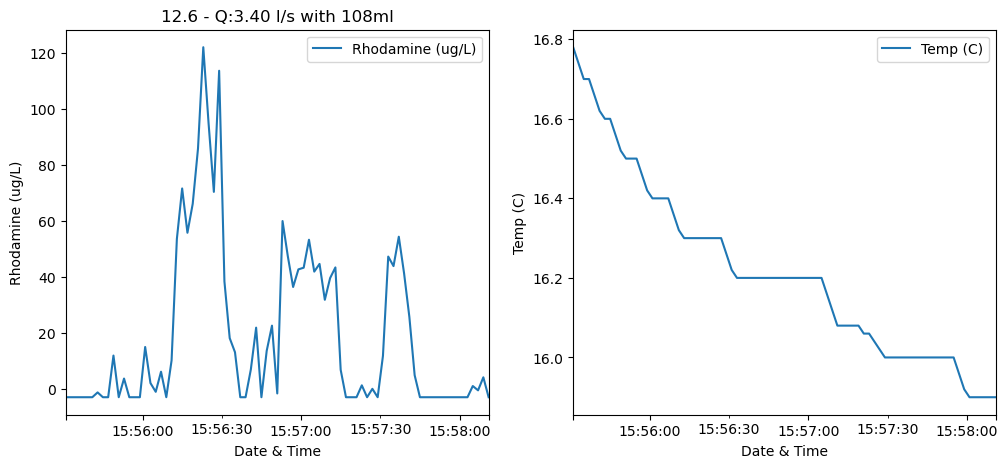

In [41]:
df2, fig2, val2 = plot(1)

$\frac{ug}{l} * s = \frac{ugs}{l}$

$ug / (ugs/l) = l/s$

In [ ]:
solution_ug_ml * 100 / scipy.integrate.simpson(df2['Rhodamine (ug/L)'].to_numpy(),dx=2)

In [ ]:
solution_ug_ml * 100 / scipy.integrate.simpson(df4['Rhodamine (ug/L)'].to_numpy(),dx=2)